In [1]:
import os
import json
import logging
import numpy as np
from tqdm import tqdm
from utils.load_dataset import load_dataset

with open("./config.json") as f:
    config = json.load(f)

logger = logging.getLogger("")
dataset_name = 'cifar100'
arch = 'resnet18'
num_augs = 2

dataset = load_dataset(
    dataset=dataset_name,
    train_batch_size=128,
    test_batch_size=128,
    val_split=0.0,
    augment=False,
    shuffle=False,
    root_path=config['data_dir'],
    random_seed=0,
    mean=[0, 0, 0],
    std=[1, 1, 1],
    logger=logger,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
def get_scores_and_masks(seeds, dataset, method, num_augs):
    h = 0.001
    num_seeds = len(seeds)
    aug_scores_file_name = {
        'curv_zo' : "curvature_scores_zo_{}_{}_{}_{}_tid{}.pt",
        'curv' : "curvature_scores_{}_{}_{}_{}_tid{}.pt",
        'prob' : "prob_{}_{}_{}_tid{}.pt",
        'loss' : "losses_{}_{}_{}_tid{}.pt",
        'mentr' : "m_entropy_{}_{}_{}_tid{}.pt",
        'loss_g' : "loss_g_{}_{}_{}_tid{}.pt",
    }

    score_seeds_v_seed = np.zeros((num_augs, dataset.train_length, num_seeds))
    mask_seeds_v_seed = np.zeros((dataset.train_length, num_seeds))
    start_seed = seeds[0]
    for exp_idx in seeds:
        array_idx = exp_idx - start_seed
        augs = 1 if method == 'mentr' else num_augs
        for aug_idx in range(augs):
            if 'curv' in aug_scores_file_name[method]:
                file_name = aug_scores_file_name[method].format(dataset.name, arch, exp_idx, h, aug_idx)
            else:
                file_name = aug_scores_file_name[method].format(dataset.name, arch, exp_idx, aug_idx)

            absolute_file_name = os.path.join(config['precomputed_scores_dir'], dataset.name, file_name)
            scores = np.load(absolute_file_name)['data']
            score_seeds_v_seed[aug_idx, :, array_idx] = scores

        if dataset == 'imagenet':
            array = np.load(f'/path/imagenet-resnet50/{0.7}/{exp_idx}/aux_arrays.npz')
            mask_idxs = array['subsample_idx']
            mask_seeds_v_seed[mask_idxs, array_idx] = 1
        else:
            mask_idxs = np.load(os.path.join(config['subset_idxs_dir'], f"{exp_idx}.npy"))
            mask_seeds_v_seed[mask_idxs, array_idx] = 1

    return score_seeds_v_seed, mask_seeds_v_seed

def get_scores_and_masks_test(seeds, dataset, method, num_augs, order_type='top'):
    h = 0.001
    num_seeds = len(seeds)
    aug_scores_file_name = {
        'curv_zo' : "curvature_scores_zo_{}_{}_{}_{}_{}_{}_tid{}.pt",
        'prob' : "prob_{}_{}_{}_{}_{}_{}_tid{}.pt",
        'loss' : "losses_{}_{}_{}_{}_{}_{}_tid{}.pt",
    }

    score_seeds_v_seed = np.zeros((num_augs, dataset.train_length, num_seeds))
    mask_seeds_v_seed = np.zeros((dataset.train_length, num_seeds))
    for array_idx, (suffix, exp_idx)  in enumerate(seeds):
        augs = 1 if method == 'mentr' else num_augs
        for aug_idx in range(augs):
            file_name = aug_scores_file_name[method].format(
                dataset.name,
                arch, 
                exp_idx, 
                order_type, 
                suffix, 
                h, 
                aug_idx)

            absolute_file_name = os.path.join(
                config['precomputed_scores_dir'], 
                f'{dataset.name}_{order_type}', file_name)

            scores = np.load(absolute_file_name)['data']
            score_seeds_v_seed[aug_idx, :, array_idx] = scores

            score_seeds_v_seed[aug_idx, :, array_idx] = scores

        if dataset == 'imagenet':
            array = np.load(f'/path/imagenet-resnet50/{0.7}/{exp_idx}/aux_arrays.npz')
            mask_idxs = array['subsample_idx']
            mask_seeds_v_seed[mask_idxs, array_idx] = 1
        else:
            if order_type == 'top':
                mask_idxs = np.load(f'./dataset_idxs/cifar100/curvature_sorted.npy')[:suffix]
            else:
                mask_idxs = np.load(f'./dataset_idxs/cifar100/random_all.npy')[:suffix]
            mask_seeds_v_seed[mask_idxs, array_idx] = 1

    return score_seeds_v_seed, mask_seeds_v_seed

def get_score_dist_params(scores, masks, num_augs):
    means_in = []
    means_out = []
    var_in = []
    var_out = []
    for aug in range(num_augs):
        in_scores = np.where(masks == 1, scores[aug], np.NaN)
        out_scores = np.where(masks == 0, scores[aug], np.NaN)
        means_in.append(np.nanmean(in_scores, axis=1))
        means_out.append(np.nanmean(out_scores, axis=1))
        var_in.append(np.nanvar(in_scores, axis=1))
        var_out.append(np.nanvar(out_scores, axis=1))

    return {
        'means_in': np.row_stack(means_in),
        'means_out': np.row_stack(means_out),
        'var_in': np.row_stack(var_in),
        'var_out': np.row_stack(var_out)
    }


In [3]:
scores = {}
masks = {}
dist_params = {}
train_end_seed = 64
train_seeds = list(range(train_end_seed))
test_seeds = [train_end_seed]
eps = 1e-32

In [4]:
def log_err(x):
    return np.log(x + eps)

def logit_scale(x):
    x = x / (1 - x + eps)
    return log_err(x)

def nll(curv_score, mean, var):
    ll = - ( ( (curv_score - mean)**2) / (2 * (var ** 2) ) ) -0.5 * np.log(var ** 2) - 0.5 * np.log(2 * np.pi)
    return -ll

def likelihood(curv_score, mean, var):
    nll = - ( ( (curv_score - mean)**2) / (2 * (var ** 2) ) ) - 0.5 * np.log(var ** 2) - 0.5 * np.log(2 * np.pi)
    likelihood_val = np.exp(nll)
    return likelihood_val

def get_likelihood_ratio(test_scores, dist_params, num_augs, train_scores, train_masks):
    in_likelihood = np.zeros((test_scores.shape[1]))
    out_likelihood = np.zeros_like(in_likelihood)
    for aug in range(num_augs):
        test_score_aug = test_scores[aug, :, 0]
        in_likelihood += likelihood(
            test_score_aug, 
            dist_params['means_in'][aug], 
            dist_params['var_in'][aug] + eps)

        out_likelihood += likelihood(
            test_score_aug, 
            dist_params['means_out'][aug], 
            dist_params['var_out'][aug] + eps)

    likelihood_ratio = in_likelihood / (out_likelihood + eps)
    return likelihood_ratio

def get_nll_ratio(test_scores, dist_params, num_augs, train_scores, train_masks):
    in_likelihood = np.zeros((test_scores.shape[1]))
    out_likelihood = np.zeros_like(in_likelihood)
    for aug in range(num_augs):
        test_score_aug = test_scores[aug, :, 0]
        in_likelihood += nll(
            test_score_aug, 
            dist_params['means_in'][aug], 
            dist_params['var_in'][aug] + eps)

        out_likelihood += nll(
            test_score_aug, 
            dist_params['means_out'][aug], 
            dist_params['var_in'][aug] + eps)

    likelihood_ratio = in_likelihood - out_likelihood
    return -likelihood_ratio

def get_nll_ratio_c(test_scores, dist_params, num_augs, train_scores, train_masks):
    in_likelihood = np.zeros((test_scores.shape[1]))
    out_likelihood = np.zeros_like(in_likelihood)
    for aug in range(num_augs):
        test_score_aug = test_scores[aug, :, 0]
        in_likelihood += nll(
            test_score_aug, 
            dist_params['means_in'][aug], 
            1)

        out_likelihood += nll(
            test_score_aug, 
            dist_params['means_out'][aug], 
            1)

    likelihood_ratio = in_likelihood - out_likelihood
    return -likelihood_ratio

def get_identity(test_scores, dist_params, num_augs, train_scores, train_masks):
    return -test_scores[0]

def get_mast(test_scores, dist_params, num_augs, train_scores, train_masks):
    aug = 0
    threshold = (dist_params['means_in'][aug] +  dist_params['means_out'][aug]) / 2 
    return -(test_scores[aug, :, 0] - threshold)

def get_mast_offline(test_scores, dist_params, num_augs, train_scores, train_masks):
    aug = 0
    threshold = dist_params['means_out'][aug]
    return -(test_scores[aug, :, 0] - threshold)

def get_ye_et_el_attack_r(test_scores, dist_params, num_augs, train_scores, train_masks):
    aug = 0
    alpha = 1e-4
    out_scores = np.where(train_masks == 0, train_scores[aug], np.NaN)
    threshold = np.nanpercentile(out_scores, alpha * 100, axis=1)
    return -(test_scores[aug, :, 0] - threshold)

def get_class_based(test_scores, dist_params, num_augs, train_scores, train_masks):
    # This is handled during roc calculations
    return -test_scores[0, :, 0]

def get_loss_count(test_scores, dist_params, num_augs, train_scores, train_masks):
    in_scores = np.where(train_masks == 1, train_scores[0], np.NaN)
    threshold = np.nanmean(in_scores)
    pred = (test_scores[:, :, 0] < threshold).sum(0) / num_augs
    return pred

methods = [
    ('curv_zo', log_err, get_nll_ratio, 'Curv ZO NLL', num_augs, train_seeds), 
    ('curv_zo', log_err, get_likelihood_ratio, 'Curv ZO LR', num_augs, train_seeds), 
    ('prob', logit_scale, get_likelihood_ratio, 'Carlini et al.', num_augs, train_seeds),
    ('loss', lambda x: x, get_identity, 'Yeom et al.', 1, [0]),
]


In [5]:
for info_type, score_func, _, method_name, augs, seeds in methods:
    if method_name in scores:
        continue
    
    score, mask = get_scores_and_masks(
        seeds=seeds, 
        dataset=dataset,
        method=info_type,
        num_augs=augs)

    score = score_func(score)
    params = get_score_dist_params(score, mask, augs)
    scores[method_name] = score
    masks[method_name] = mask
    dist_params[method_name] = params

/tmp/ipykernel_28321/3153369307.py:92: RuntimeWarning: Mean of empty slice
  means_in.append(np.nanmean(in_scores, axis=1))
/tmp/ipykernel_28321/3153369307.py:93: RuntimeWarning: Mean of empty slice
  means_out.append(np.nanmean(out_scores, axis=1))
/tmp/ipykernel_28321/3153369307.py:94: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_in.append(np.nanvar(in_scores, axis=1))
/tmp/ipykernel_28321/3153369307.py:95: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_out.append(np.nanvar(out_scores, axis=1))


In [6]:
from sklearn.metrics import roc_auc_score, roc_curve, balanced_accuracy_score

def find_tpr_at_fpr(tpr, fpr, target_fpr=1e-1):
    """
    Finds the TPR when FPR equals target_fpr using interpolation.

    Parameters:
    tpr (array): Array of true positive rates.
    fpr (array): Array of false positive rates.
    target_fpr (float): The target false positive rate. Default is 1e-1.

    Returns:
    float: Interpolated TPR at the target FPR.
    """
    # Ensure the arrays are numpy arrays
    tpr = np.array(tpr)
    fpr = np.array(fpr)

    # Use numpy's interpolation function
    tpr_at_target_fpr = np.interp(target_fpr, fpr, tpr)
    return tpr_at_target_fpr

def get_metrics_for_method(method_name, dataset, y_true, y_pred):
    if method_name == 'Song et al.':
        labels_file_name = os.path.join(
            config['precomputed_scores_dir'], 
            dataset.name, 
            f"true_labels_cifar100_{train_end_seed}.pt")
        labels = np.load(labels_file_name)['data']
        
        auc = 0 
        n_classes = dataset.num_classes
        balanced_accuracy = 0
        for label in range(n_classes):
            indices = np.where(labels == label)[0]
            # Compute ROC curve for each class
            fpr, tpr, thr = roc_curve(y_true[indices], y_pred[indices])
            auc += roc_auc_score(y_true, y_pred)
            
            # Find the optimal threshold: where the sum of FPR and TPR is closest to 1
            optimal_idx = np.argmin(np.abs(fpr + tpr - 1))
            optimal_threshold = thr[optimal_idx]
            # Binarize predictions based on the optimal threshold
            y_pred_binarized = (y_pred >= optimal_threshold).astype(int)

            # Calculate Balanced Accuracy
            balanced_accuracy += balanced_accuracy_score(y_true, y_pred_binarized)
        
        auc = auc / n_classes
        balanced_accuracy = balanced_accuracy / n_classes

    else:
        fpr, tpr, thr = roc_curve(y_true, y_pred, pos_label=1)
        auc = roc_auc_score(y_true, y_pred)
        tpr1p_base = find_tpr_at_fpr(tpr, fpr, target_fpr=1e-2)
        tpr01p_base = find_tpr_at_fpr(tpr, fpr, target_fpr=1e-3)

        # Find the optimal threshold: where the sum of FPR and TPR is closest to 1
        # "Balanced accuracy is symmetric. That is, the metric
        # assigns equal cost to false-positives and to false-negatives."
        # - LiRA https://arxiv.org/pdf/2112.03570.pdf
        optimal_idx = np.argmin(np.abs(fpr + tpr - 1))
        optimal_threshold = thr[optimal_idx]

        # if auc < 0.5:
        #     # Binarize predictions based on the optimal threshold
        #     auc = 1 - auc
        #     y_pred_binarized = (y_pred <= optimal_threshold).astype(int)
        # else:
        # Binarize predictions based on the optimal threshold
        y_pred_binarized = (y_pred >= optimal_threshold).astype(int)

        # Calculate Balanced Accuracy
        balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binarized)

    return auc, balanced_accuracy, tpr1p_base, tpr01p_base

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, balanced_accuracy_score
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['ieee', 'science', 'grid'])

accs_for_pu_trade_off = {}
bal_acc_for_pu_trade_off = {}
tpr1p_trade_off = {}
tpr01p_trade_off = {}
plot_auroc = {}
plot_acc = {}
plot_m = {}
order_types = ['random']
for order_type in order_types:
    accs_for_pu_trade_off[order_type] = {}
    bal_acc_for_pu_trade_off[order_type] = {}
    plot_auroc[order_type] = {}
    plot_acc[order_type] = {}
    plot_m[order_type] = {}
    tpr1p_trade_off[order_type] = {}
    tpr01p_trade_off[order_type] = {}
    for info_type, score_func, _, method_name, augs, seeds in methods:
        plot_auroc[order_type][method_name] = []
        plot_acc[order_type][method_name] = []
        plot_m[order_type][method_name] = []
        bal_acc_for_pu_trade_off[order_type][method_name] = {}
        tpr1p_trade_off[order_type][method_name] = {}
        tpr01p_trade_off[order_type][method_name] = {}

for order_type in order_types:
    test_scores = {}
    test_masks = {}
    test_exps = [0, 1]

    test_len = [500, 1000, 3000, 7000, 10000, 12000, 15000, 18000, 20000, 25000, 30000, 35000, 45000]
    test_seeds = []
    for t_len in test_len:
        for t_exp_idx in test_exps:
            test_seeds.append((t_len, t_exp_idx))

    for info_type, score_func, _, method_name, augs, _ in methods:
        test_score, test_mask = get_scores_and_masks_test(
            seeds=test_seeds, 
            dataset=dataset,
            method=info_type,
            num_augs=augs,
            order_type=order_type)

        test_scores[method_name] = score_func(test_score)
        test_masks[method_name] = test_mask

    
    for _, (info_type, _, pred_func, method_name, augs, _) in enumerate(methods):
        aurocs = {}
        accs = {}
        m = {}
        tpr1p = {}
        tpr01p = {}

        for t_seed_idx, (train_len, seed) in enumerate(test_seeds):
            y_pred = pred_func(
                test_scores[method_name][..., t_seed_idx, np.newaxis],
                dist_params[method_name],
                augs,
                scores[method_name],
                masks[method_name])

            y_true = test_masks[method_name][..., t_seed_idx, np.newaxis] #[:1000]
            auc, balanced_accuracy, tp1p, tp01p = get_metrics_for_method(method_name, dataset, y_true, y_pred)
            print(f"AUC {method_name} {train_len}: {auc*100:.2f}, Acc {balanced_accuracy * 100:.2f}")
            print(f"TPR 1% {method_name} {train_len}: {tp1p*100:.2f}, TPR 0.1% {tp01p * 100:.2f}")
            
            if train_len in m:
                accs[train_len].append(balanced_accuracy)
                aurocs[train_len].append(auc)
                m[train_len].append(train_len)
                tpr1p[train_len].append(tp1p)
                tpr01p[train_len].append(tp01p)
            else:
                accs[train_len] = [balanced_accuracy]
                aurocs[train_len] = [auc]
                m[train_len] = [train_len]                
                tpr1p[train_len] = [tp1p]
                tpr01p[train_len] = [tp01p]

        for key in m.keys():
            plot_acc[order_type][method_name].append(np.array(accs[key]).mean())
            auroc = np.array(aurocs[key]).mean()
            plot_auroc[order_type][method_name].append(auroc)
            plot_m[order_type][method_name].append(np.array(m[key]).mean())
            if key in accs_for_pu_trade_off[order_type]:
                accs_for_pu_trade_off[order_type][key] += [(aurocs[key], method_name)]
                bal_acc_for_pu_trade_off[order_type][key] += [(accs[key], method_name)]
                tpr1p_trade_off[order_type][key] += [(tpr1p[key], method_name)]
                tpr01p_trade_off[order_type][key] += [(tpr01p[key], method_name)]
            else:
                accs_for_pu_trade_off[order_type][key] = [(aurocs[key], method_name)]
                bal_acc_for_pu_trade_off[order_type][key] = [(accs[key], method_name)]
                tpr1p_trade_off[order_type][key] = [(tpr1p[key], method_name)]
                tpr01p_trade_off[order_type][key] = [(tpr01p[key], method_name)]


AUC Curv ZO NLL 500: 90.47, Acc 77.24
TPR 1% Curv ZO NLL 500: 40.80, TPR 0.1% 12.80
AUC Curv ZO NLL 500: 90.13, Acc 76.40
TPR 1% Curv ZO NLL 500: 41.20, TPR 0.1% 12.80
AUC Curv ZO NLL 1000: 92.51, Acc 82.13
TPR 1% Curv ZO NLL 1000: 41.20, TPR 0.1% 9.70
AUC Curv ZO NLL 1000: 93.11, Acc 83.79
TPR 1% Curv ZO NLL 1000: 38.70, TPR 0.1% 7.50
AUC Curv ZO NLL 3000: 95.37, Acc 87.61
TPR 1% Curv ZO NLL 3000: 42.60, TPR 0.1% 5.83
AUC Curv ZO NLL 3000: 95.20, Acc 87.47
TPR 1% Curv ZO NLL 3000: 41.63, TPR 0.1% 8.33
AUC Curv ZO NLL 7000: 94.60, Acc 86.83
TPR 1% Curv ZO NLL 7000: 42.37, TPR 0.1% 6.53
AUC Curv ZO NLL 7000: 95.63, Acc 87.62
TPR 1% Curv ZO NLL 7000: 46.66, TPR 0.1% 5.34
AUC Curv ZO NLL 10000: 94.17, Acc 86.35
TPR 1% Curv ZO NLL 10000: 39.09, TPR 0.1% 6.09
AUC Curv ZO NLL 10000: 93.93, Acc 86.27
TPR 1% Curv ZO NLL 10000: 38.06, TPR 0.1% 5.64
AUC Curv ZO NLL 12000: 94.16, Acc 86.06
TPR 1% Curv ZO NLL 12000: 39.17, TPR 0.1% 6.11
AUC Curv ZO NLL 12000: 94.29, Acc 86.28
TPR 1% Curv ZO NLL 12

In [8]:
import pickle

with open("./dataset_idxs/cifar100/cifar100_random_model_acc.pkl", "rb") as f:
    random_perf = pickle.load(f)

random_samples = {}
random_per = {}
random_per_mia = {}
random_mia = {}
random_mia_std = {}
random_tpr1p = {}
random_tpr01p = {}

for info_type, score_func, _, method_name, augs, seeds in methods:
    random_samples[method_name] = []
    random_per[method_name] = []
    random_per_mia[method_name] = []
    random_mia_std[method_name] = []
    random_mia[method_name] = []
    random_tpr1p[method_name] = []
    random_tpr01p[method_name] = []

for idx, (info_type, score_func, _, method_name, augs, _) in enumerate(methods):
    for k, v in random_perf.items():
        if k not in accs_for_pu_trade_off['random']:
            continue
        random_samples[method_name].append(k)
        acc = np.array(v).mean()
        random_per[method_name].append(acc)
        accs_mia = np.array(accs_for_pu_trade_off['random'][k][idx][0])
        random_mia[method_name].append(accs_mia.mean())
        random_mia_std[method_name].append(accs_mia.std())
        # print(f"{method_name} {k}: {accs_mia},")
        random_per_mia[method_name].append(acc/(100 * accs_mia.mean()))
        random_tpr1p[method_name].append(np.array(tpr1p_trade_off['random'][k][idx][0]).mean())
        random_tpr01p[method_name].append(np.array(tpr01p_trade_off['random'][k][idx][0]).mean())

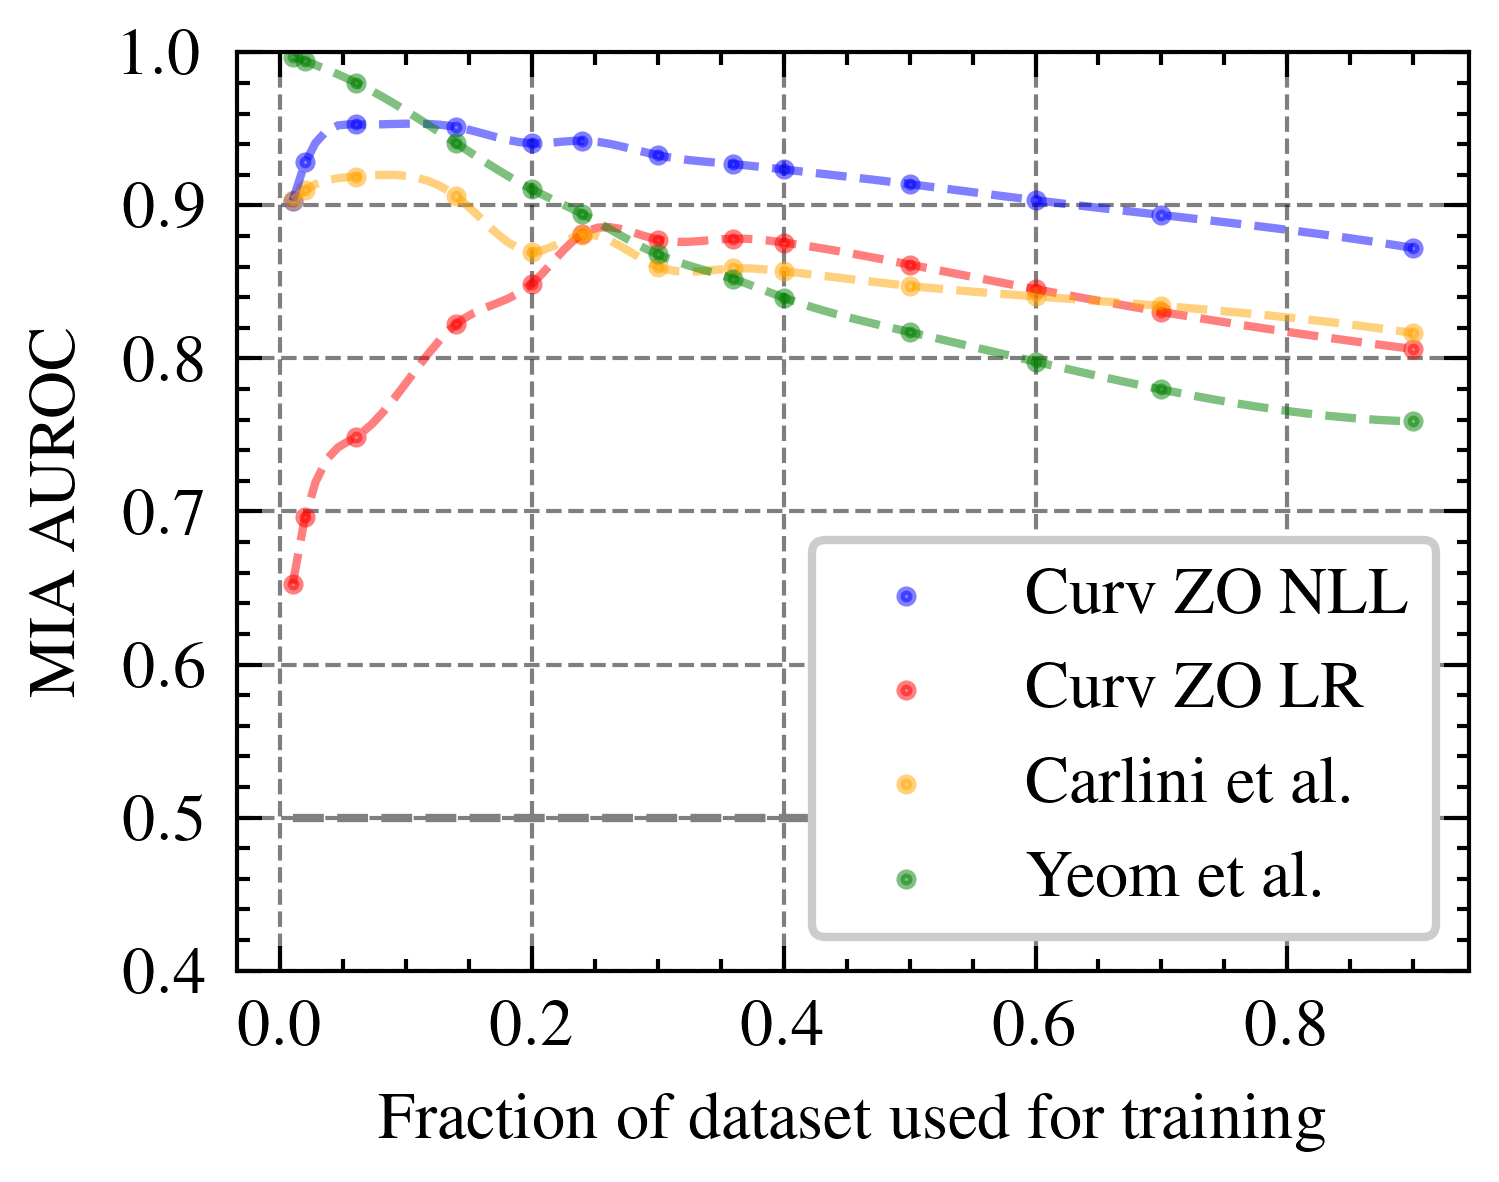

In [9]:
from scipy.interpolate import make_interp_spline
import pandas as pd

textwidth = 3.31314
aspect_ratio = 6/8
scale = 0.8
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
colors = ['blue', 'red', 'orange', 'green']
for idx, (info_type, score_func, _, method_name, augs, seeds) in enumerate(methods):
    
    df_rand = pd.DataFrame({
        'samples': random_samples[method_name],
        'p_u_t': random_mia[method_name],
        'std': random_mia_std[method_name],
        'tpr1p': random_tpr1p[method_name],
        'tpr01p': random_tpr01p[method_name]
    })

    df_rand = df_rand.sort_values(by='samples')

    # Calculate the upper and lower bounds for the shaded area
    upper_bound = df_rand['p_u_t'].values + df_rand['std'].values
    lower_bound = df_rand['p_u_t'].values - df_rand['std'].values

    n = 4
    coefficients = np.polyfit(df_rand['samples'].values / 50000, df_rand['p_u_t'].values, n)
    polynomial = np.poly1d(coefficients)

    plt.scatter(df_rand['samples'].values / 50000, df_rand['p_u_t'].values, color=colors[idx], label=f'{method_name}', alpha=0.5, s=2)

    x = df_rand['samples'].values / 50000

    # Generate x values for the polynomial line
    x_poly = np.linspace(min(x), max(x), 100)
    
    spline = make_interp_spline(x, df_rand['p_u_t'].values)
    y_poly = spline(x_poly)

    # Plot the polynomial fit
    plt.plot(x_poly, y_poly, color=colors[idx], alpha=0.5, ls='dashed', lw=1)


plt.plot(df_rand['samples'].values / 50000, np.ones_like(df_rand['samples'].values) * 0.5, color='gray', ls='dashed')
plt.ylabel("MIA AUROC")
plt.xlabel("Fraction of dataset used for training")
plt.legend()
plt.ylim(0.4, 1.0)
plt.show()
plt.savefig("./plots/privacy_v_random.png")
plt.savefig("./plots/privacy_v_random.svg")

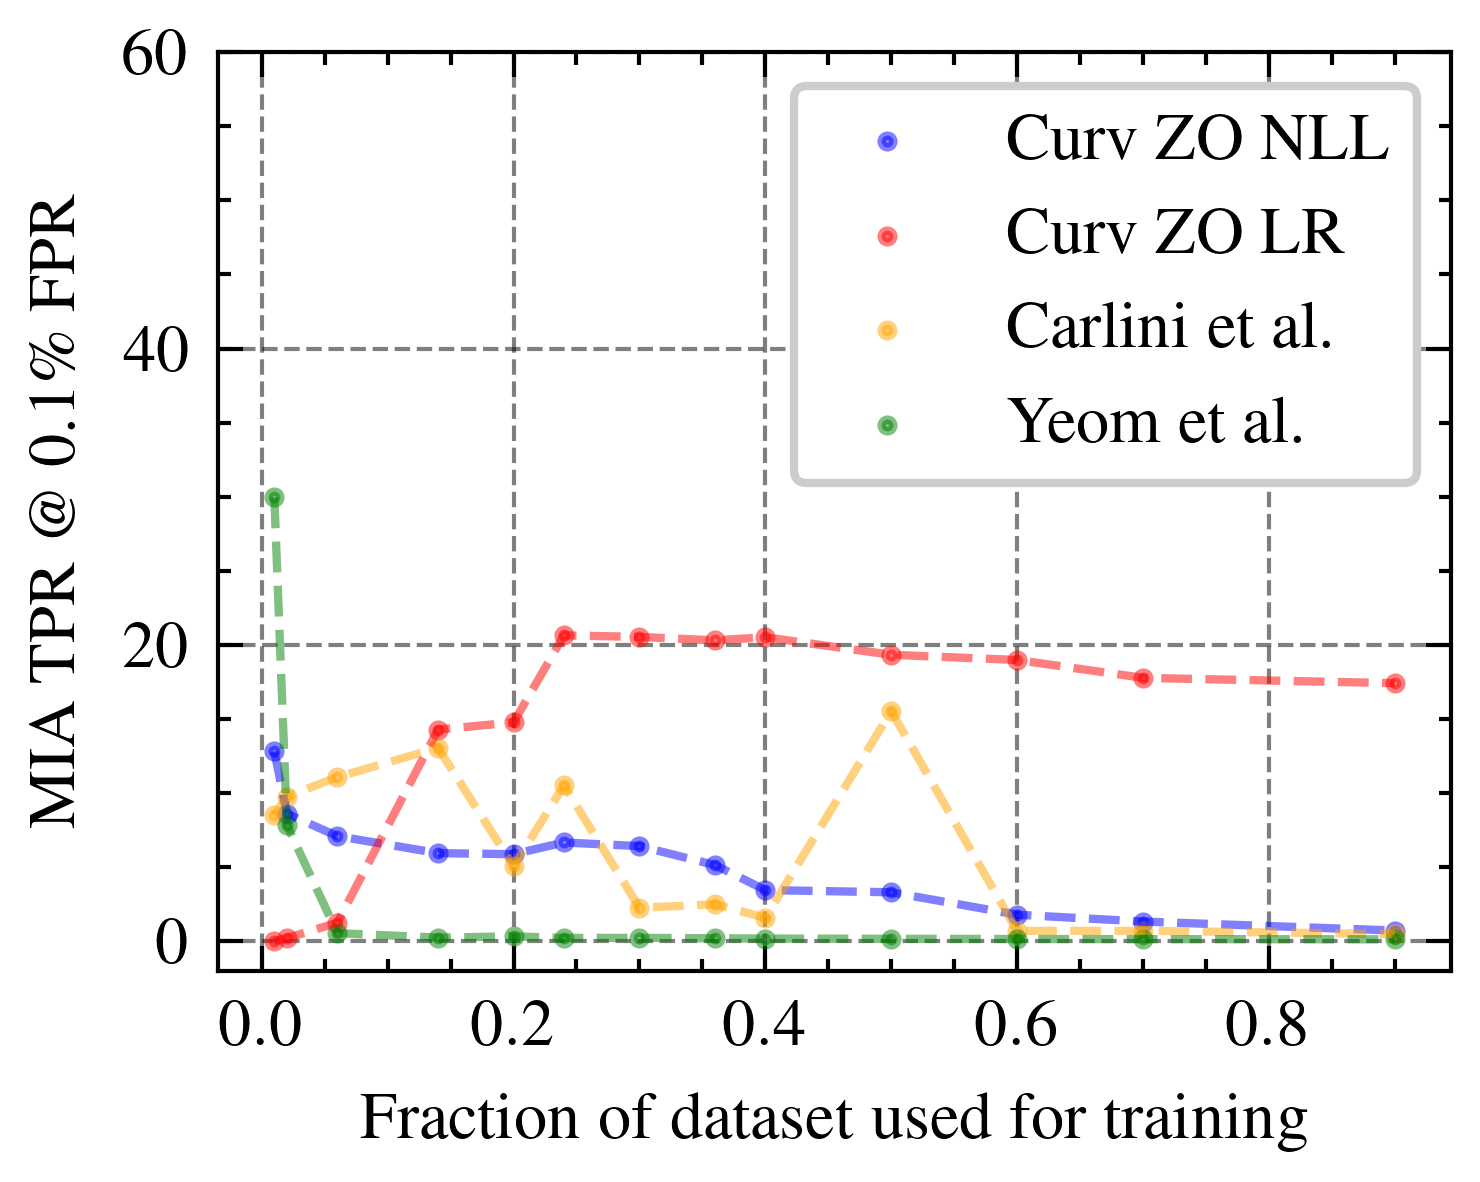

In [11]:
from scipy.interpolate import make_interp_spline

textwidth = 3.31314
aspect_ratio = 6/8
scale = 0.8
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
colors = ['blue', 'red', 'orange', 'green']
for idx, (info_type, score_func, _, method_name, augs, seeds) in enumerate(methods):

    
    df_rand = pd.DataFrame({
        'samples': random_samples[method_name],
        'p_u_t': random_tpr01p[method_name],
        'std': random_mia_std[method_name],
        'tpr1p': random_tpr1p[method_name],
        'tpr01p': random_tpr01p[method_name]
    })

    # Use the best result for Carilini et al. from
    if 'Car' in method_name:
        df_rand.loc[df_rand['samples'] == 25000, 'p_u_t'] = 0.1552

    df_rand = df_rand.sort_values(by='samples')

    # Calculate the upper and lower bounds for the shaded area
    upper_bound = df_rand['p_u_t'].values + df_rand['std'].values
    lower_bound = df_rand['p_u_t'].values - df_rand['std'].values

    n = 3
    if idx == 3:
        n = 9
    
    coefficients = np.polyfit(df_rand['samples'].values / 50000, df_rand['p_u_t'].values * 100, n)
    polynomial = np.poly1d(coefficients)

    plt.scatter(df_rand['samples'].values / 50000, df_rand['p_u_t'].values * 100, color=colors[idx], label=f'{method_name}', alpha=0.5, s=2)

    x = df_rand['samples'].values / 50000

    # Generate x values for the polynomial line
    x_poly = np.linspace(min(x), max(x), 100)
    
    spline = make_interp_spline(x, df_rand['p_u_t'].values, k=n)
    y_poly = spline(x_poly) *100

    # Plot the polynomial fit
    plt.plot(df_rand['samples'].values / 50000, df_rand['p_u_t'].values * 100, color=colors[idx], alpha=0.5, ls='dashed', lw=1)

plt.ylabel("MIA TPR @ 0.1\% FPR")
plt.xlabel("Fraction of dataset used for training")
plt.legend()
plt.ylim(-2, 60.0)
plt.show()
plt.savefig("./plots/privacy_v_random_tpr.png")
plt.savefig("./plots/privacy_v_random_tpr.svg")